In [1]:
Pkg.add("Gadfly")
using Gadfly
using DataFrames

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of Gadfly
INFO: Use `Pkg.update()` to get the latest versions of your packages


# Parameters

In [2]:
@enum DataSource concentriccircles=1 spiral=2

samples_per_class = 100; # number of data points per class
data_distortion = 0.5; # set to 0 for no distortion
data_source = spiral; # spiral or circle
num_classes = 2; # number of different classes
regularization = 1e-3 # regularization strength
step_size = 1e-2
iterations = 500

const num_dimensions = 2; # Number of dimensions (x, y), changing this will break all plotting

# computed values
N = samples_per_class * num_classes

# Generate our data sets

In [3]:
# generate data
function getCircle(dots, radius, x=0, y=0)
    angles = randn(dots).*(2*pi)
    xs = cos(angles).*radius.+x
    ys = sin(angles).*radius.+y
    return [ xs ys ]
end

function getSpiral(dots, degrees, rate=1.0)
    angles = linspace(0, degrees, dots)
    radii = angles.*rate
    X = [ f(angles[i]) * radii[i] for i in 1:dots, f in [cos, sin]]
end

if data_source == concentriccircles
    Data = getCircle(samples_per_class, 1.5)
    Labels = ones(Int64, samples_per_class)
    for i in 2:num_classes
        Data = vcat(Data, getCircle(samples_per_class, i*1.5))
        Labels = vcat(Labels, ones(Int64, samples_per_class).*i)
    end
elseif data_source == spiral
    Data = getSpiral(samples_per_class, 2*pi, 1.5)
    Labels = ones(Int64, samples_per_class)
    for i in 2:num_classes
        Data = vcat(Data, getSpiral(samples_per_class, 2*pi, i*1.5))
        Labels = vcat(Labels, ones(Int64, samples_per_class).*i)
    end
end

In [4]:
# Visualization helper functions

function predictClasses(data, weights, bias)
    scores = data * weights + repmat(bias, size(data, 1))
    exp_scores = e.^scores
    _, max_indices = findmax(exp_scores', 1)
    transpose((max_indices-1)%num_classes+1)
end

function output_learning_status_image(index, weights, bias)
    data = [ [x y] for x in linspace(-20, 20, 50), y in linspace(-30, 20, 50) ]
    data = vcat(data...)
    data = convert(DataFrame, [data predictClasses(data, weights, bias)])
    original_data = convert(DataFrame, [DistortedData Labels])
    p = plot(
        layer(original_data, x=:x1, y=:x2, color=:x3, Geom.point),
        layer(data, x=:x1, y=:x2, color=:x3, Geom.point, Theme(point_shapes=[hline]))
    )
    draw(SVGJS("./images/test_$(lpad(index,3,0)).js.svg", 6inch, 6inch), p)
end

function plot_data(df)
    plot(df, x=:x1, y=:x2, color=:x3, Geom.point)
end

plot_data (generic function with 1 method)

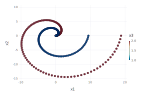

In [5]:
plot_data(convert(DataFrame, [Data Labels]))

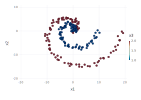

In [6]:
# Add some randominzation to the dataset
DistortedData = Data + randn(N, num_dimensions).*data_distortion;
plot_data(convert(DataFrame, [DistortedData Labels]))

# Implement linear regression

In [7]:
function linear_regression(data, labels)
    
    # randomly initialize weights
    W = randn(num_dimensions, num_classes)

    # randomly initialize bias vector
    b = zeros(1, num_classes)
    
    # compute the gradient on normalized_scores
    gradient = zeros(N, num_classes)
    for (index, label_idx) in enumerate(labels)
        gradient[index, Int64(label_idx)] = -1
    end

    # begine linear regression
    for iter in 1:iterations

        # compute scores
        scores = data * W + repmat(b, N)

        # compute normalized log probabilities (e^scores)
        exp_scores = e.^scores

        # e^scores / ( sum(e^scores) )
        normalized_scores = exp_scores ./ repmat(sum(exp_scores, 2)', size(exp_scores, 2))'

        # normalized log-likelyhood -log(e^scores / ( sum(e^scores)))
        normalized_log_likelyhood = -log(exp_scores)
        total_error = sum(normalized_log_likelyhood)/N + 0.5*regularization*sum(W.*W)
        if iter < 10 || (iter % 10 == 0 && iter <= 100) || iter % 100 == 0
            println("ITER: $(iter), ERROR: $(total_error)")
            output_learning_status_image(iter, W, b)
        end
        
        # log likelihood gradient
        dscores = exp_scores - gradient
        dscores = scores ./ N
        dW = data'*dscores + regularization.*W 
        db = sum(dscores, 1)
        
        W += -step_size .* dW
        b += -step_size * db
    end
    return W, b
end

linear_regression (generic function with 1 method)

In [8]:
Weights, Bias = linear_regression(DistortedData, Labels);

ITER: 1, ERROR: 5.369620869091167
ITER: 2, ERROR: 3.0140868305328006
ITER: 3, ERROR: 1.7044226039334631
ITER: 4, ERROR: 0.9661075948406892
ITER: 5, ERROR: 0.5430633122526698
ITER: 6, ERROR: 0.2961394775250372
ITER: 7, ERROR: 0.14907292844531436
ITER: 8, ERROR: 0.059618840846331476
ITER: 9, ERROR: 0.004068320829510044
ITER: 10, ERROR: -0.031094972970748595
ITER: 20, ERROR: -0.09408300485002048
ITER: 30, ERROR: -0.08829205592147252
ITER: 40, ERROR: -0.08114218035855768
ITER: 50, ERROR: -0.0745122759075459
ITER: 60, ERROR: -0.06842198590427402
ITER: 70, ERROR: -0.06282941348540784
ITER: 80, ERROR: -0.05769395555028807
ITER: 90, ERROR: -0.052978251958487606
ITER: 100, ERROR: -0.04864799355897526
ITER: 200, ERROR: -0.02073662159538508
ITER: 300, ERROR: -0.00883916125980845
ITER: 400, ERROR: -0.0037677675817955995
ITER: 500, ERROR: -0.0016060429312524725
